# Bogacki Shampine method & Duffing's equation

[Bogacki-Shampine's](https://doi.org/10.1016/0898-1221%2896%2900141-1) method of order (4,5) is used to solve Duffing's equation (E3 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set).

The class `BS45` codes the method as intended by Bogacki and Shampine. It contains a highly accurate fifth order interpolant. The class `BS45_i` is a variation with a fourth order interpolant of lower accuracy. This interpolant is free: it does not require extra fucntion evaluations. The difference between the two methods will be demonstrated.

## Problem definition

Duffing's equation models a mass spring system with a non-linear spring. In this case, the system is undamped, with a softening spring and a sinusoidal exitation force.

In [9]:
from math import sin

problem = {'fun' : lambda t, y: [y[1], y[0]**3/6 - y[0] + 2*sin(2.78535*t)],
            'y0' : [0., 0.],
        't_span' : [0., 20.]}

## Reference solution

First, a reference solution is created by solving this problem with low tolerance and the high order method `DOP853`.

In [10]:
from scipy.integrate import solve_ivp

reference = solve_ivp(**problem, atol=1e-12, rtol=1e-12, method='DOP853', dense_output=True)

## Solution plot

A plot gives an idea about the solution. The response appears to have two sine components.

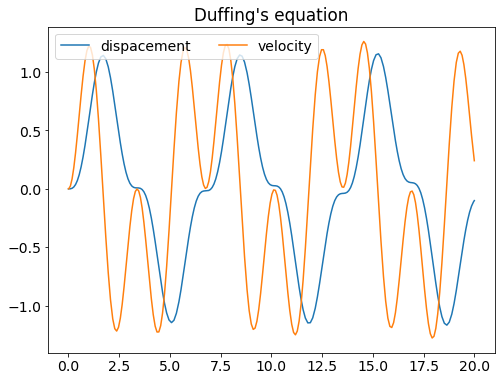

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 14

plt.figure()
plt.plot(reference.t, reference.y.T)
plt.title("Duffing's equation")
plt.legend(('dispacement', 'velocity'), ncol=2)
plt.show()

## Efficiency plot
The method is efficient if it can solve problems to low error with low cost. I will use the number of function evaluations as measure of cost. For the error measure I wil use the RMS of the error norm over all solution points. A function to calculate it is:

In [12]:
def rms_err_norm(solution, reference):
    error = solution.y - reference.sol(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

So how well do the methods of Bogacki and Shampine `BS45` and `BS45_i` solve the Duffing problem? To answer this question, the solution is calculated for multiple absolute tolerance values with these methods and with the `RK45` method. Plotting the number of function evaluations versus the error shows their relative efficiency.

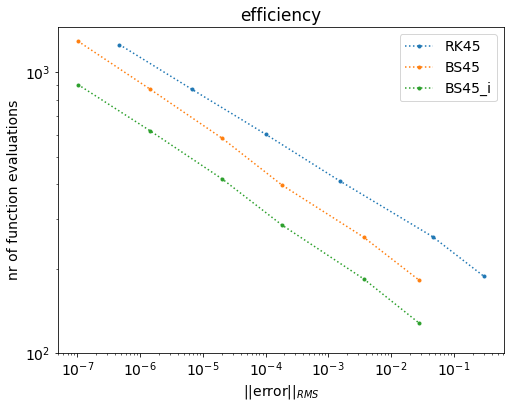

In [13]:
import numpy as np
from extensisq import BS45, BS45_i

methods = ['RK45', BS45, BS45_i]
tolerances = np.logspace(-7, -2, 6)

plt.figure()
solutions = []
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method,
                dense_output=True)       # this triggers the extra function calls in BS45
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    solutions.append(sol)                # save only high tol solution
    plt.loglog(e, n, '.:', label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.ylim(ymin=1e2)
plt.show()     

The plot shows that `BS45_i` is roughly twice (!) as efficient as `RK45`, scipy's default method. This graph also shows that `BS45` needs more function evaluations (for the accurate fifth order interpolant), but is still more efficient than `RK45`.

## Interpolation

Notice in the plot how the errors of `BS45` and `BS45_i` are exactly the same for a given tolerance value. This is expected, since the only diference between the two methods is the interpolant. Let's take a closer look at the interpolation accuracy *in-between* the solution points.

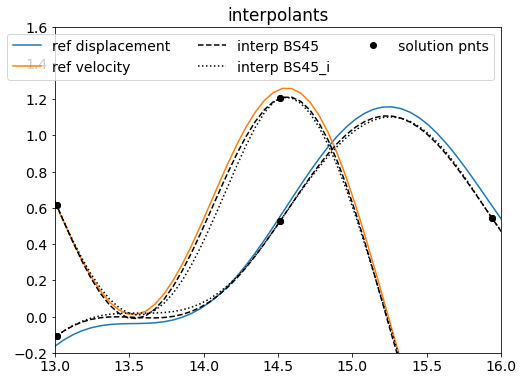

In [14]:
x_plot = np.linspace(13, 16)
styles = ['--k', ':k']

plt.figure()
plt.plot(x_plot, reference.sol(x_plot).T, label='ref solution')
for i in range(2):
    for sol, style in zip(solutions[1:], styles):
        plt.plot(x_plot, sol.sol(x_plot)[i], style)
    plt.plot(solutions[i+1].t, solutions[i+1].y.T, 'ko')
plt.xlim((x_plot.min(), x_plot.max()))
plt.ylim((-0.2, 1.6))
plt.legend(('ref displacement', 'ref velocity', 'interp BS45', 'interp BS45_i', 'solution pnts' ), ncol=3)
plt.title('interpolants')
plt.show()

This is a solution with a very high tolerance value. The method takes very large steps. The interpolation between the solution points is different for the two methods and the accurate interpolant of `BS45` better resembles the reference solution than the free interpolant of `BS45_i`. On the other hand, the global error (of the solution points) is larger than the difference between the interpolants. Therefore, the extra evaluations seem better spent at solving the problem with lower tolerance. This yields almost an order of magnitude of improvement in the error according to the efficiency plot.

Dense interpolation is triggered by:
* `dense_output`: extra evaluations for all successful steps.
* `t_eval`: extra evaluations only for steps where output is requested.
* `events`: extra evaluations only at steps in which an event is detected. 

The two methods `BS45` and `BS45_i` are the identical if none of these are used.

Bogacki and Shampine have develloped the accurate interpolant in `BS45` for use on a small fraction of the steps, not for all steps. It is very useful with `events`, and maybe in some cases with `t_eval`. However, `BS45_i` is a better choice in combination with `dense_output=True`, as demonstrated above.


## Discussion
The Bogacki Shampine method solves this Duffing's equation much more efficiently than scipy's default method `RK45`. Of course, the problem was selected for this reason. Nevertheless, `BS45` and `BS45_i` will be more efficient for many other problems as well. For some problems (not this Duffing problem) it may need somewhat more stringent tolerances than the default values of `solve_ivp` to really shine.